# Figure 1

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import scrublet as scr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("white")

sc.settings.verbosity=3

In [4]:
import os, sys
sys.path.append(f"{os.getcwd()}/../code")
from plotting.plot_settings import *
from plotting.palettes import *
from plotting.util import fix_main_adata_annos

In [5]:
from plotting.fig1 import summary_figure_1d, summary_figure_1e

## Load data

In [6]:
data_dir = f"{os.getcwd()}/../data"

In [7]:
main = sc.read(f"{data_dir}/main.h5ad")

In [22]:
mye = sc.read(f"{data_dir}/mye.h5ad")
epi = sc.read(f"{data_dir}/epi.h5ad")
stro = sc.read(f"{data_dir}/stro.h5ad")
endo = sc.read(f"{data_dir}/endo.h5ad")

In [8]:
fig_dir = f"{os.getcwd()}/../figures"

In [9]:
fix_main_adata_annos(main)

## Subsample major populations

In [87]:
main.obs["is_cdc2"] = False
main.obs.loc[mye.obs_names, "is_cdc2"] = mye.obs.subtypes.isin(["cDC2"])
main.obs["is_lyve1"] = False
main.obs.loc[mye.obs_names, "is_lyve1"] = mye.obs.subtypes.isin(["M$\Phi$1-LYVE1"])
main.obs["is_ccl19"] = False
main.obs.loc[stro.obs_names, "is_ccl19"] = stro.obs.subtypes.isin(["Prv-CCL19"])
main.obs["is_muc5b"] = False
main.obs.loc[epi.obs_names, "is_muc5b"] = epi.obs.subtypes.isin(["MUC5B+"])

In [93]:
main.obs["target"] = "none"
main.obs.loc[main.obs.is_lyve1, "target"] = "lyve1"
main.obs.loc[main.obs.is_ccl19, "target"] = "ccl19"
main.obs.loc[main.obs.is_muc5b, "target"] = "muc5b"
main.obs.loc[main.obs.is_cdc2, "target"] = "cdc2"

In [94]:
idxs = [main.obs_names[main.obs.celltype_main.isin([ct])] for ct in main.obs.celltype_main.cat.categories]

In [187]:
trials = []
for _ in range(10000):
    vals = main.obs.loc[np.hstack([np.random.choice(i, size=1000) for i in idxs]), ["target", "sample_type_rename"]]
    trials.append(vals.groupby(["target", "sample_type_rename"]).size() / 5000 * 100)

In [188]:
t = pd.concat(trials, axis=0).reset_index()
t.columns = t.columns.tolist()[:-1] + ["frac"]
t2 = t.loc[~t.target.isin(["none"]), :]

In [189]:
truth = main.obs.groupby(["target", "sample_type_rename"]).size() / main.obs.shape[0] * 100
truth = truth.drop("none", axis=0).reset_index()
truth.columns = truth.columns.tolist()[:-1] + ["frac"]

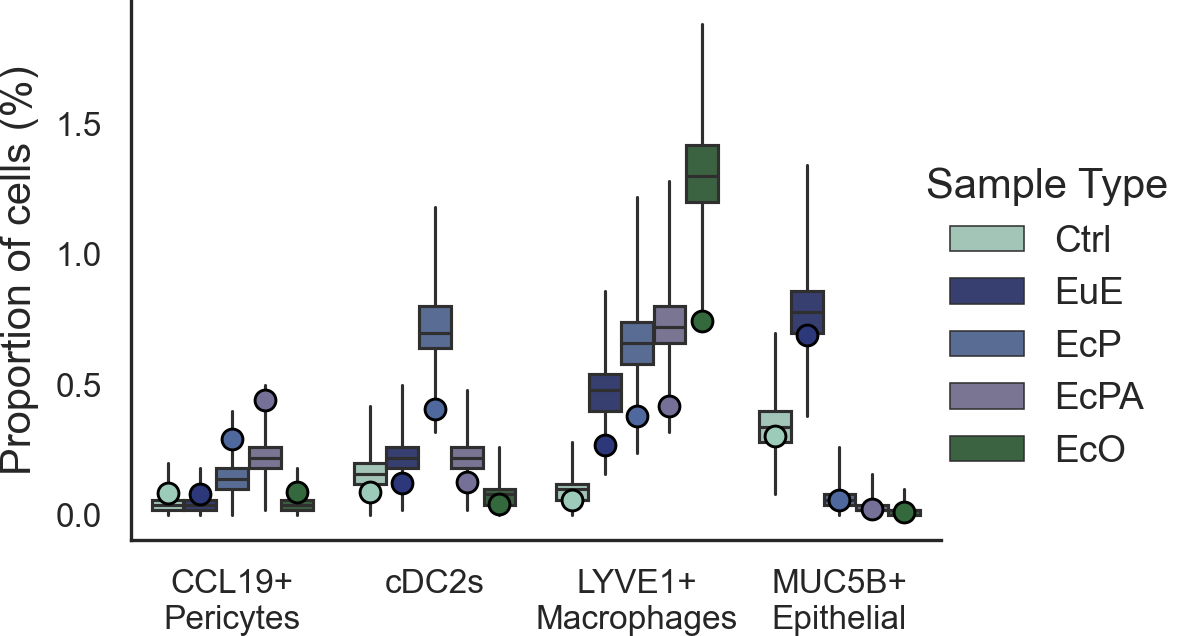

In [195]:
g = sns.catplot(
    data=t2, y="frac", x="target", hue="sample_type_rename", kind="box", 
    linewidth=0.75, whis=[0,100], capprops={"lw":0}, palette=sample_type_palette
)
sns.stripplot(
    data=truth, y="frac", x="target", hue="sample_type_rename", dodge=True, 
    jitter=0, ax=g.ax, edgecolor="k", linewidth=0.7, palette=sample_type_palette
)
g.ax.set_xlabel("")
g.ax.set_ylabel("Proportion of cells (%)")
g.ax.set_xticklabels([
    "CCL19+\nPericytes", "cDC2s", "LYVE1+\nMacrophages", "MUC5B+\nEpithelial"
])
leg = g.ax.get_legend()
leg.remove()
g.legend.set_title("Sample Type")
g.fig.set_size_inches((4, 2))